In [1]:
import os
import pandas as pd 
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
train_path = "./train"
test_path =  "./test"

## Prepare Train Data

In [3]:
emotion_list = os.listdir(train_path)
categories = []
name_of_image = []
for emotion in emotion_list:
    filenames = os.listdir(train_path+ '/' + emotion)
    for filename in filenames:
        name_of_image.append(filename)
        categories.append(emotion)

In [4]:
df = pd.DataFrame({
    'Filename' : name_of_image,
    'Category' : categories
})

In [5]:
class_name = emotion_list
class_name

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
df['Category'] = df['Category'].replace({'angry': 0, 'disgust': 1, 'fear' : 2, 'happy' : 3, 'neutral' : 4, 'sad' : 5, 'surprise' : 6})

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,Filename,Category
0,Training_10595751.jpg,0
1,Training_97004687.jpg,3
2,Training_38300126.jpg,6
3,Training_24511742.jpg,0
4,Training_65838035.jpg,6


<Axes: >

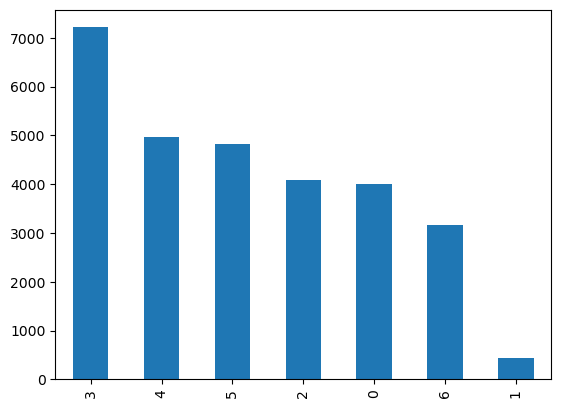

In [9]:
df['Category'].value_counts().plot.bar()

surprise


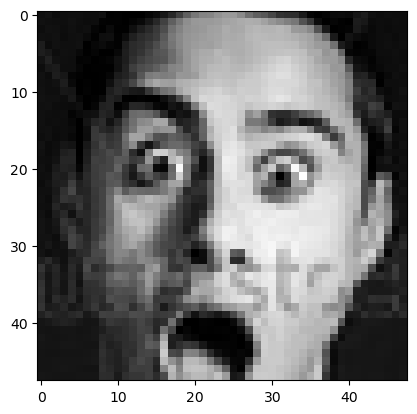

In [13]:
random_number = random.randint(0,df.shape[0])
image = load_img(train_path + '/' + class_name[df.iloc[random_number][1]] + '/' + df.iloc[random_number][0])
print(class_name[df.iloc[random_number][1]])
plt.imshow(image)

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=32)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

## Train Data Generation

In [15]:
train_generation = ImageDataGenerator(
    width_shift_range= 0.1,
    height_shift_range= 0.1,
    horizontal_flip = True,
    rescale= 1/255,
    validation_split = 0.2
)

validation_generation = ImageDataGenerator(
    rescale = 1/255,
    validation_split = 0.2
)

In [17]:
train_generator = train_generation.flow_from_directory(
    directory = train_path,
    target_size = (48, 48),        
    batch_size = 64,           
    color_mode = "grayscale",  
    class_mode = "categorical",   
    subset = "training",
    classes = class_name
)
validation_generator = validation_generation.flow_from_directory(
    directory = test_path,
    target_size = (48, 48),        
    batch_size = 64,        
    color_mode = "grayscale",        
    class_mode = "categorical",      
    subset = "validation",
    classes = class_name
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [18]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow as tf 

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(class_name), activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_callback]
)

Epoch 1/50
359/359 [==============================] - ETA: 0s - loss: 2.7559 - accuracy: 0.1882
Epoch 1: val_accuracy improved from -inf to 0.15782, saving model to model_weights.h5
359/359 [==============================] - 161s 425ms/step - loss: 2.7559 - accuracy: 0.1882 - val_loss: 2.0092 - val_accuracy: 0.1578
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 2.3529 - accuracy: 0.2370
Epoch 2: val_accuracy improved from 0.15782 to 0.34218, saving model to model_weights.h5
359/359 [==============================] - 22s 61ms/step - loss: 2.3529 - accuracy: 0.2370 - val_loss: 1.7341 - val_accuracy: 0.3422
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 2.1708 - accuracy: 0.2712
Epoch 3: val_accuracy improved from 0.34218 to 0.39735, saving model to model_weights.h5
359/359 [==============================] - 22s 60ms/step - loss: 2.1708 - accuracy: 0.2712 - val_loss: 1.6062 - val_accuracy: 0.3973
Epoch 4/50
359/359 [===========================

In [20]:
model.save("model.h5")